In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
# Step 1: Register custom font with Matplotlib
font_path = '/Users/henrismidt/Documents/Informatik/Fonts/libertinus/LibertinusSerif-Regular.otf'
font_manager.fontManager.addfont(font_path)  # Register the font with Matplotlib

# Step 2: Update Matplotlib's RC settings to use font by default
plt.rcParams['font.family'] = 'Libertinus Serif'

In [1]:
from utils import LoginCredentials
import wandb

authenticator = LoginCredentials()

wandb.login(key=authenticator.wandb_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: finnhenri-smidt. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/henrismidt/.netrc


True

In [2]:
import torch
from torchvision import transforms
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
import wandb


from dataset import MRIImageDataModule, MRIDataset
from models import MobileViTLightning
from utils import get_best_device
from datetime import datetime


import lightning.pytorch as pl
import torch
import numpy as np
import random

def set_reproducibility(seed=42):
    # Set Python random seed
    random.seed(seed)
    
    # Set Numpy seed
    np.random.seed(seed)
    
    # Set PyTorch seed
    torch.manual_seed(seed)
    
    # If using CUDA:
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Control sources of nondeterminism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # PyTorch Lightning utility to seed everything
    pl.seed_everything(seed, workers=True)

# Example of setting up a reproducible environment
set_reproducibility(42)


Seed set to 42


## Configure Dataloader

In [3]:
from transformers import MobileViTImageProcessor
# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
def transform(image):
    # Use MobileViTImageProcessor for preprocessing
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

csv_path = 'Data/metadata_for_preprocessed_files.csv'
data_module = MRIImageDataModule(csv_path, slice_number=70, transform=transform, batch_size=1)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model = MobileViTLightning(model_ckpt=model_ckpt, num_labels=4)
print(type(model)) 
trainer = L.Trainer(max_epochs=5, devices='auto', accelerator='auto')
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-x-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/

<class 'models.mobilevit_lightning.MobileViTLightning'>


Training: |          | 0/? [00:00<?, ?it/s]

/Users/henrismidt/Documents/Informatik/Master/Alzheimer_Detection/dataset.py:58: PerformanceWarning: indexing past lexsort depth may impact performance.
  rows = self.df.loc[(id, slice_num)]
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/Users/henrismidt/Documents/Informatik/Master/Alzheimer_Detection/dataset.py:47: PerformanceWarning: indexing past lexsort depth may impact performance.
  float_label = self.df.loc[(id, self.slice_number)]['CDR'].iloc[0]
/Users/henrismidt/Documents/Informatik/Master/Alzheimer_Detection/dataset.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  age = torch.tensor(self.df.loc[(id, self.slice_number)]['Age']).float()
`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
import torch
from torchvision import transforms
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from transformers import MobileViTImageProcessor
import wandb

from dataset import MRIImageDataModule, MRIDataset
from models import MobileViTLightning
from utils import get_best_device, LoginCredentials

from datetime import datetime
import lightning.pytorch as pl
import torch
import numpy as np
import random
from sklearn.metrics import f1_score

authenticator = LoginCredentials()
wandb.login(key=authenticator.wandb_key)

def set_reproducibility(seed=42):
    # Set Python random seed
    random.seed(seed)
    
    # Set Numpy seed
    np.random.seed(seed)
    
    # Set PyTorch seed
    torch.manual_seed(seed)
    
    # If using CUDA:
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Control sources of nondeterminism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # PyTorch Lightning utility to seed everything
    pl.seed_everything(seed, workers=True)

# Example of setting up a reproducible environment
set_reproducibility(42)

# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
def transform(image):
    # Use MobileViTImageProcessor for preprocessing
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Define sweep configuration
sweep_config = {
    'method': 'grid',
    'parameters': {
        'slice_number': {
            'values': list(range(20, 140, 3))  # Values: 20, 17, 14
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project="Alzheimer-Detection")

# Define the training function
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config

        data_module = MRIImageDataModule(csv_path, slice_number=config.slice_number, transform=transform, batch_size=48, num_workers=0)
        data_module.setup()
        train_loader = data_module.train_dataloader()
        val_loader = data_module.val_dataloader()
        test_loader = data_module.test_dataloader()

        model = MobileViTLightning(model_ckpt=model_ckpt, num_labels=4)

        wandb_logger = WandbLogger()

        checkpoint_callback = ModelCheckpoint(
            dirpath='model_checkpoints',
            filename=f'slice_numer_{config.slice_number}',
            monitor='val_loss',
            mode='min',
            save_top_k=1
        )

        trainer = L.Trainer(
            max_epochs=20,
            devices='auto',
            accelerator='auto',
            logger=wandb_logger,
            callbacks=[checkpoint_callback],
            log_every_n_steps=24
        )

        trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

        # Load best model for testing
        # best_model_path = checkpoint_callback.best_model_path
        # best_model = MobileViTLightning.load_from_checkpoint(best_model_path, model_ckpt=model_ckpt, num_labels=4)

        # # Evaluate on test set
        # best_model.eval()
        # all_preds = []
        # all_labels = []
        # for batch in test_loader:
        #     inputs, labels = batch
        #     outputs = best_model(inputs)
        #     preds = torch.argmax(outputs, dim=1)
        #     all_preds.extend(preds.cpu().numpy())
        #     all_labels.extend(labels.cpu().numpy())

        # f1 = f1_score(all_labels, all_preds, average='weighted')
        # wandb.log({'test_f1_score': f1})

# Run the sweep
wandb.agent(sweep_id, function=train)


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-x-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprec

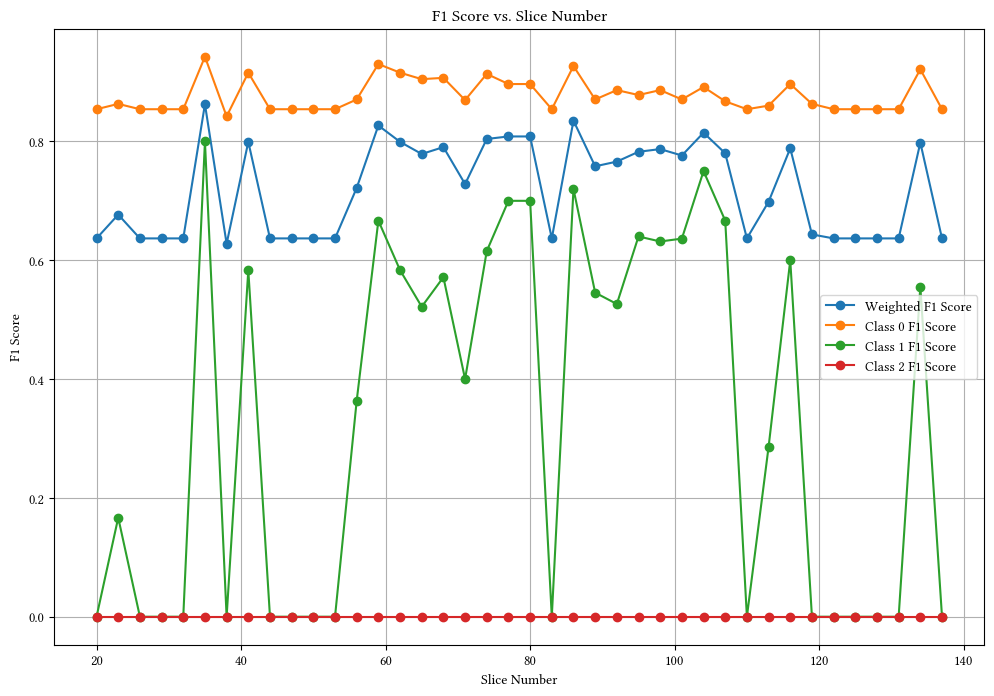

In [3]:
import torch
import pandas as pd
from transformers import MobileViTImageProcessor
from sklearn.metrics import f1_score
import os
import numpy as np
import matplotlib.pyplot as plt
from dataset import MRIImageDataModule
from models import MobileViTLightning
from utils import get_best_device

# Set device
device = get_best_device()

# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
def transform(image):
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

# Path to the CSV file
csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Function to evaluate a model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, _, _ = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)
    return weighted_f1, per_class_f1

# List to store the results
results = []

# Iterate over the saved models
for slice_number in range(20, 140, 3):
    model_path = f'model_checkpoints/slice_numer_{slice_number}.ckpt'
    if not os.path.exists(model_path):
        continue
    # Load the model
    model = MobileViTLightning.load_from_checkpoint(model_path, model_ckpt=model_ckpt, num_labels=4)
    model = model.to(device)
    # Initialize the data module
    data_module = MRIImageDataModule(csv_path, slice_number=slice_number, transform=transform, batch_size=48, num_workers=0)
    data_module.setup()
    test_loader = data_module.test_dataloader()
    # Evaluate the model
    weighted_f1, per_class_f1 = evaluate_model(model, test_loader)
    
    # Append the result
    result = {'slice_number': slice_number, 'weighted_f1_score': weighted_f1}
    for i, class_f1 in enumerate(per_class_f1):
        result[f'class_{i}_f1_score'] = class_f1
    results.append(result)

# Create a DataFrame
df = pd.DataFrame(results)

# Save the DataFrame
df.to_csv('model_evaluation_results.csv', index=False)

# Plot the F1 score against the slice number
plt.figure(figsize=(12, 8))

# Plot weighted F1 score
plt.plot(df['slice_number'], df['weighted_f1_score'], marker='o', linestyle='-', label='Weighted F1 Score')

# Plot per-class F1 scores
for i in range(4):  # Assuming 4 classes
    if f'class_{i}_f1_score' in df.columns:
        plt.plot(df['slice_number'], df[f'class_{i}_f1_score'], marker='o', linestyle='-', label=f'Class {i} F1 Score')

plt.title('F1 Score vs. Slice Number')
plt.xlabel('Slice Number')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import torch
import pandas as pd
from transformers import MobileViTImageProcessor
import os
from dataset import MRIImageDataModule
from models import MobileViTLightning
from utils import get_best_device

# Set device
device = get_best_device()

# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the MRI dataset
def transform(image):
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

# Path to the CSV file
csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Dictionary to store predictions and labels
results_dict = {'id': []}

# Iterate over the saved models
for slice_number in range(20, 140, 3):
    model_path = f'model_checkpoints/slice_numer_{slice_number}.ckpt'
    if not os.path.exists(model_path):
        continue
    # Load the model
    model = MobileViTLightning.load_from_checkpoint(model_path, model_ckpt=model_ckpt, num_labels=4)
    model = model.to(device)
    model.eval()
    # Initialize the data module
    data_module = MRIImageDataModule(csv_path, slice_number=slice_number, transform=transform, batch_size=48, num_workers=0)
    data_module.setup()
    test_loader = data_module.test_dataloader()
    # Perform inference and store predictions
    all_preds = []
    all_labels = []
    all_ids = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, age, ids = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_ids.extend(ids)
    # Store predictions and labels
    if 'labels' not in results_dict:
        results_dict['labels'] = all_labels
    results_dict[f'slice_{slice_number}'] = all_preds
    if not results_dict['id']:
        results_dict['id'] = all_ids

# Convert dictionary to DataFrame
df_results = pd.DataFrame(results_dict)

# Ensure rows are sorted by MRI ID
df_results = df_results.sort_values(by='id')

# Save DataFrame to CSV
df_results.to_csv('model_predictions.csv', index=False)

# Load DataFrame from CSV (example usage)
df_loaded = pd.read_csv('model_predictions.csv')

# Display DataFrame
print(df_loaded.head())


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-x-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprec

              id  labels  slice_20  slice_23  slice_26  slice_29  slice_32  \
0  OAS1_0015_MR1       1         1         1         0         0         0   
1  OAS1_0018_MR1       0         0         0         0         0         0   
2  OAS1_0030_MR1       0         0         0         0         0         0   
3  OAS1_0032_MR1       0         0         0         0         0         0   
4  OAS1_0042_MR1       1         0         0         0         0         0   

   slice_35  slice_38  slice_41  ...  slice_110  slice_113  slice_116  \
0         1         0         1  ...          0          0          0   
1         0         0         0  ...          0          0          0   
2         0         0         0  ...          0          1          0   
3         0         1         0  ...          0          0          0   
4         1         0         1  ...          0          0          1   

   slice_119  slice_122  slice_125  slice_128  slice_131  slice_134  slice_137  
0          

/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_26133/4227294598.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='f1_score', data=metrics_df, palette='viridis')


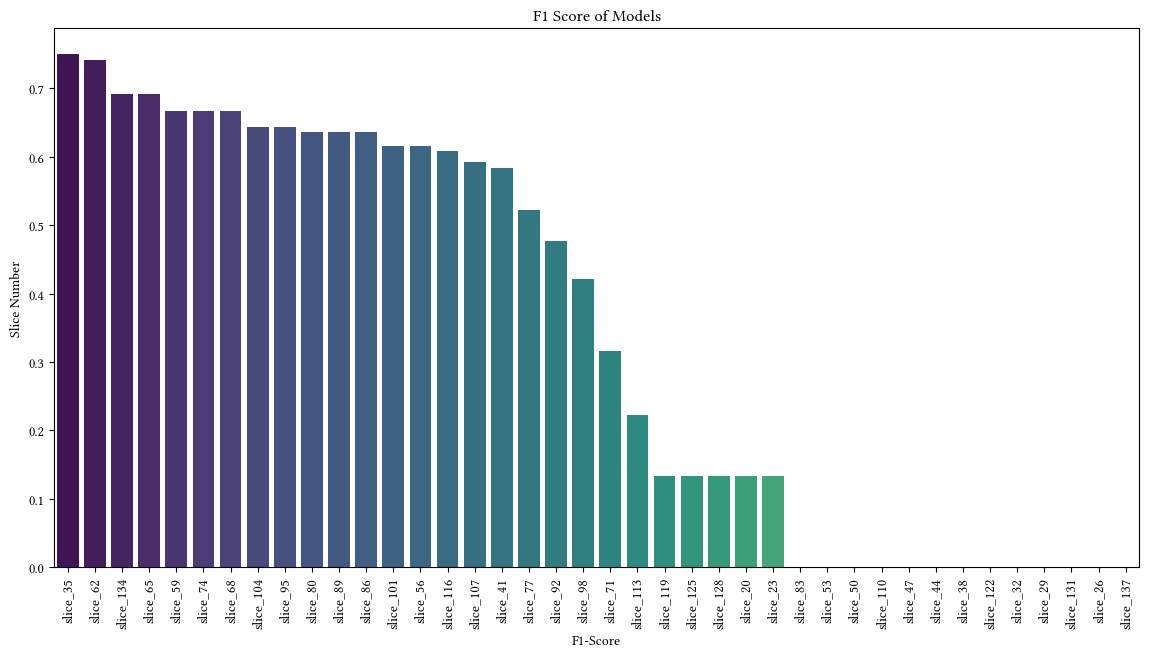

/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_26133/4227294598.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='unique_correct', data=metrics_df, palette='viridis')


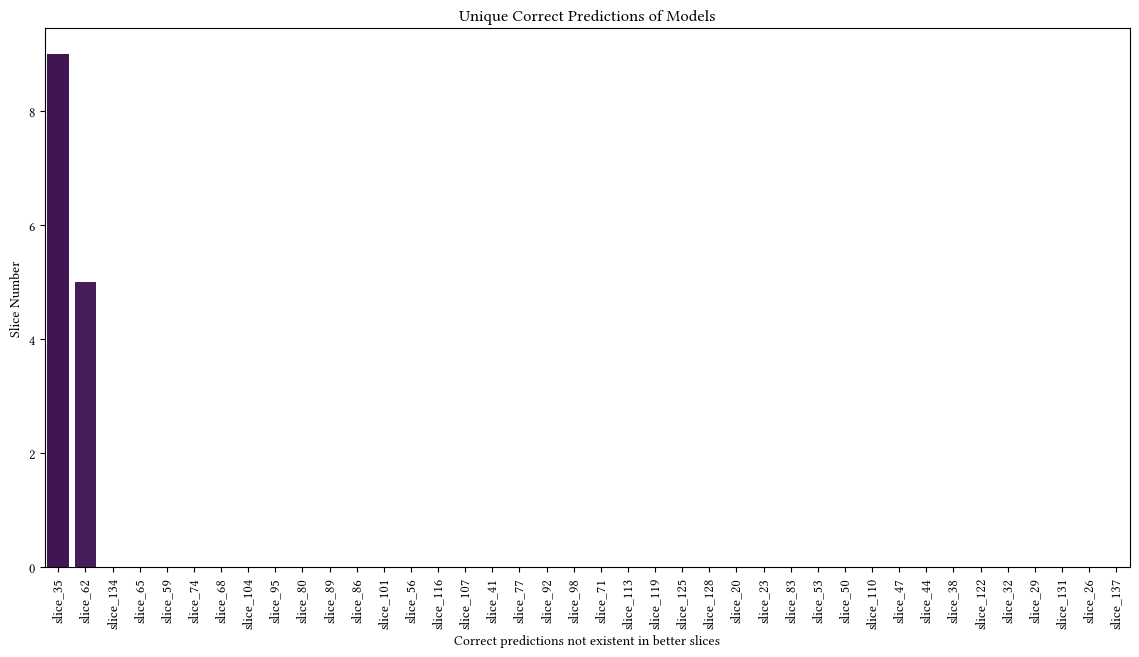

,model,accuracy,precision,recall,f1_score,unique_correct
0,slice_35,0.890909,0.900000,0.642857,0.750000,9
1,slice_62,0.872727,0.769231,0.714286,0.740741,5
2,slice_134,0.854545,0.750000,0.642857,0.692308,0
3,slice_65,0.854545,0.750000,0.642857,0.692308,0
4,slice_59,0.854545,0.800000,0.571429,0.666667,0
5,slice_74,0.836364,0.692308,0.642857,0.666667,0
6,slice_68,0.854545,0.800000,0.571429,0.666667,0
7,slice_104,0.818182,0.642857,0.642857,0.642857,0
8,slice_95,0.818182,0.642857,0.642857,0.642857,0
9,slice_80,0.854545,0.875000,0.500000,0.636364,0


In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is the DataFrame with the data
# Step 1: Preprocess the Data
df = df_loaded
df['new_labels'] = df['labels'].apply(lambda x: 1 if x in [1, 2] else 0)

# Step 2: Evaluate Model Performance
metrics = []
slice_columns = [col for col in df.columns if col.startswith('slice_')]

for col in slice_columns:
    accuracy = accuracy_score(df['new_labels'], df[col])
    precision = precision_score(df['new_labels'], df[col], zero_division=0)
    recall = recall_score(df['new_labels'], df[col], zero_division=0)
    f1 = f1_score(df['new_labels'], df[col], zero_division=0)
    
    metrics.append({
        'model': col,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Sort by F1 score
metrics_df = metrics_df.sort_values(by='f1_score', ascending=False).reset_index(drop=True)

# Step 3: Calculate unique correct predictions
unique_correct = []
all_correct_predictions = np.zeros(df.shape[0], dtype=bool)

for index, row in metrics_df.iterrows():
    model_predictions = df[row['model']].astype(bool)
    correct_predictions = (df['new_labels'] == model_predictions) & (df['new_labels'] == 1)
    unique_correct_predictions = correct_predictions & (~all_correct_predictions)
    unique_correct_count = unique_correct_predictions.sum()
    unique_correct.append(unique_correct_count)
    
    # Update the all correct predictions
    all_correct_predictions |= correct_predictions

metrics_df['unique_correct'] = unique_correct

# Step 4: Visualization
plt.figure(figsize=(14, 7))
sns.barplot(x='model', y='f1_score', data=metrics_df, palette='viridis')
plt.title('F1 Score of Models')
plt.xticks(rotation=90)
plt.ylabel('Slice Number')
plt.xlabel('F1-Score')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='model', y='unique_correct', data=metrics_df, palette='viridis')
plt.title('Unique Correct Predictions of Models')
plt.xticks(rotation=90)
plt.ylabel('Slice Number')
plt.xlabel('Correct predictions not existent in better slices')
plt.show()


# Display the metrics dataframe
metrics_df


In [13]:
import torch
import pandas as pd
from transformers import MobileViTImageProcessor
import os
from dataset import MRIImageDataModule
from models import MobileViTLightning
from utils import get_best_device
import numpy as np

# Set device
device = get_best_device()

# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the MRI dataset
def transform(image):
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

# Path to the CSV file
csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Dictionary to store predictions and labels
results_dict = {'id': []}

# Number of inferences to run
n = 10

# Iterate over the saved models
for slice_number in range(20, 140, 3):
    model_path = f'model_checkpoints/slice_numer_{slice_number}.ckpt'
    if not os.path.exists(model_path):
        continue
    # Load the model
    model = MobileViTLightning.load_from_checkpoint(model_path, model_ckpt=model_ckpt, num_labels=4)
    model = model.to(device)
    model.eval()
    
    # Initialize the data module
    data_module = MRIImageDataModule(csv_path, slice_number=slice_number, transform=transform, batch_size=48, num_workers=0)
    data_module.setup()
    test_loader = data_module.test_dataloader()
    
    # Store predictions and labels for multiple runs
    run_preds = []
    
    for _ in range(n):
        all_preds = []
        all_labels = []
        all_ids = []
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels, age, ids = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_ids.extend(ids)
        run_preds.append(all_preds)
    
    # Calculate mean and std of predictions
    run_preds = np.array(run_preds)
    preds_mean = np.mean(run_preds, axis=0)
    preds_std = np.std(run_preds, axis=0)
    
    # Store predictions and labels
    if 'labels' not in results_dict:
        results_dict['labels'] = all_labels
    results_dict[f'slice_{slice_number}_mean'] = preds_mean
    results_dict[f'slice_{slice_number}_std'] = preds_std
    if not results_dict['id']:
        results_dict['id'] = all_ids

# Convert dictionary to DataFrame
df_results = pd.DataFrame(results_dict)

# Ensure rows are sorted by MRI ID
df_results = df_results.sort_values(by='id')

# Save DataFrame to CSV
df_results.to_csv('model_predictions.csv', index=False)

# Load DataFrame from CSV (example usage)
df_loaded = pd.read_csv('model_predictions.csv')

# Display DataFrame
print(df_loaded.head())


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-x-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprec

              id  labels  slice_20_mean  slice_20_std  slice_23_mean  \
0  OAS1_0015_MR1       1            0.3      0.458258            0.7   
1  OAS1_0018_MR1       0            0.0      0.000000            0.0   
2  OAS1_0030_MR1       0            0.0      0.000000            0.0   
3  OAS1_0032_MR1       0            0.0      0.000000            0.1   
4  OAS1_0042_MR1       1            0.0      0.000000            0.0   

   slice_23_std  slice_26_mean  slice_26_std  slice_29_mean  slice_29_std  \
0      0.458258            0.0           0.0            0.0           0.0   
1      0.000000            0.0           0.0            0.0           0.0   
2      0.000000            0.0           0.0            0.0           0.0   
3      0.300000            0.0           0.0            0.0           0.0   
4      0.000000            0.0           0.0            0.0           0.0   

   ...  slice_125_mean  slice_125_std  slice_128_mean  slice_128_std  \
0  ...             0.0          

/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_26133/1236669792.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='f1_score', data=metrics_df, palette='viridis')


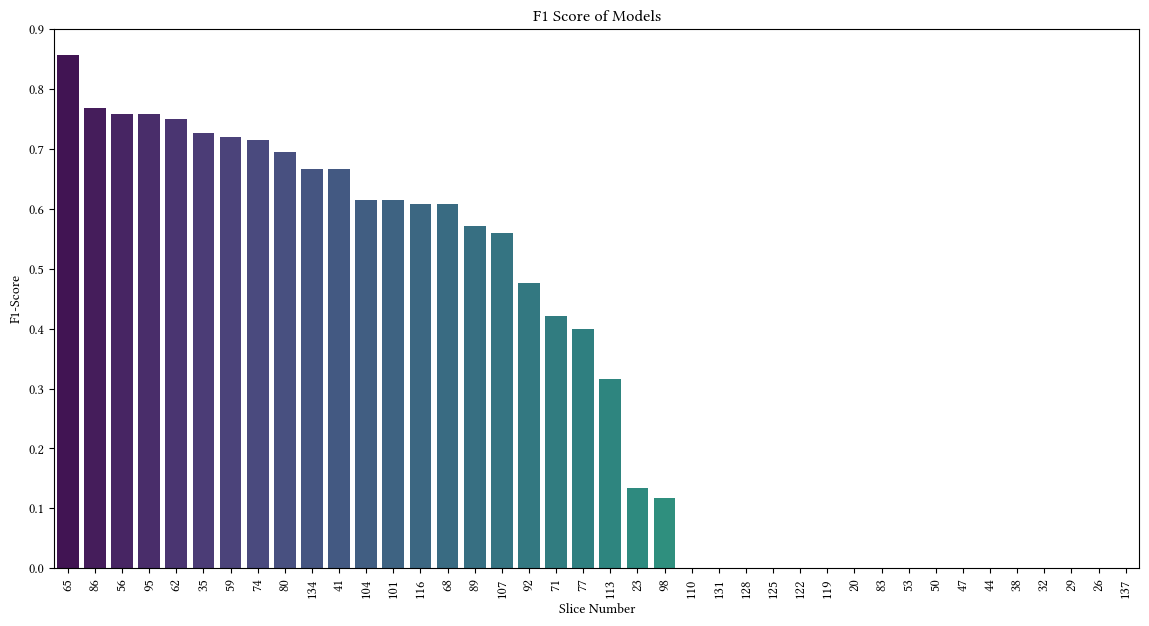

/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_26133/1236669792.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='unique_correct', data=metrics_df, palette='viridis')


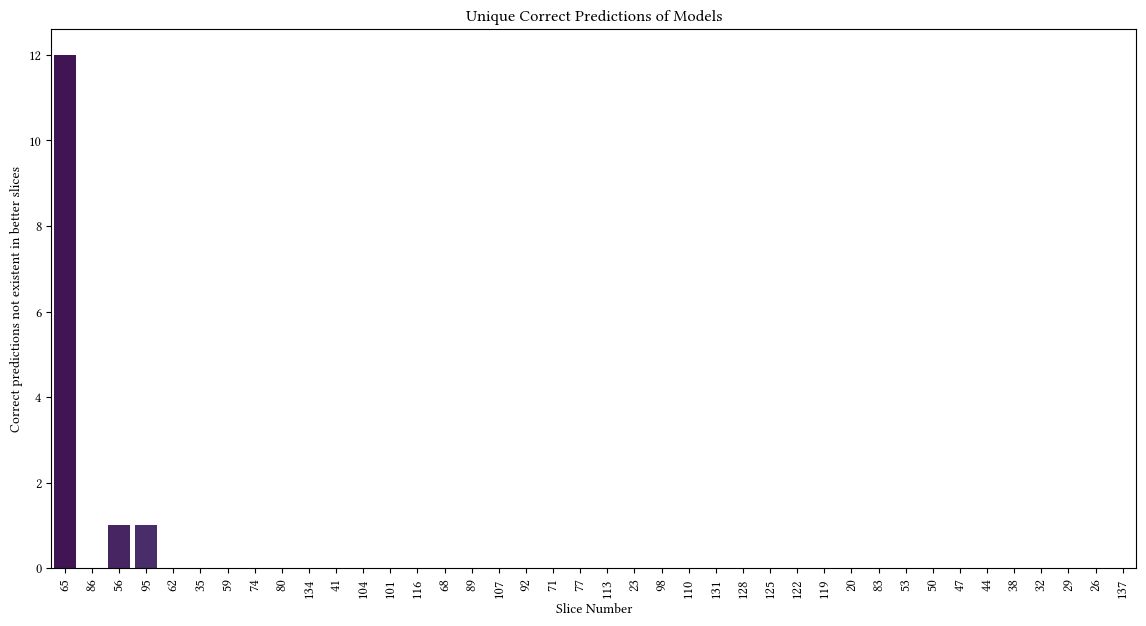

,model,accuracy,precision,recall,f1_score,std_dev,unique_correct
0,65,0.927273,0.857143,0.857143,0.857143,0.069691,12
1,86,0.890909,0.833333,0.714286,0.769231,0.100601,0
2,56,0.872727,0.733333,0.785714,0.758621,0.065271,1
3,95,0.872727,0.733333,0.785714,0.758621,0.091626,1
4,62,0.890909,0.900000,0.642857,0.750000,0.069966,0
5,35,0.890909,1.000000,0.571429,0.727273,0.104745,0
6,59,0.872727,0.818182,0.642857,0.720000,0.094111,0
7,74,0.854545,0.714286,0.714286,0.714286,0.060300,0
8,80,0.872727,0.888889,0.571429,0.695652,0.099933,0
9,134,0.872727,1.000000,0.500000,0.666667,0.085871,0


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Preprocess the Data
df = df_loaded
df['new_labels'] = df['labels'].apply(lambda x: 1 if x in [1, 2] else 0)

# Step 2: Evaluate Model Performance
metrics = []
slice_columns = [col for col in df.columns if col.endswith('_mean')]

for col in slice_columns:
    # Convert mean predictions to binary using 0.5 as threshold
    binary_predictions = (df[col] > 0.5).astype(int)
    
    accuracy = accuracy_score(df['new_labels'], binary_predictions)
    precision = precision_score(df['new_labels'], binary_predictions, zero_division=0)
    recall = recall_score(df['new_labels'], binary_predictions, zero_division=0)
    f1 = f1_score(df['new_labels'], binary_predictions, zero_division=0)
    
    slice_number = col.split('_')[1]
    metrics.append({
        'model': slice_number,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'std_dev': df[f'slice_{slice_number}_std'].mean()
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Sort by F1 score
metrics_df = metrics_df.sort_values(by='f1_score', ascending=False).reset_index(drop=True)

# Step 3: Calculate unique correct predictions
unique_correct = []
all_correct_predictions = np.zeros(df.shape[0], dtype=bool)

for index, row in metrics_df.iterrows():
    model_predictions = (df[f'slice_{row["model"]}_mean'] > 0.5).astype(bool)
    correct_predictions = (df['new_labels'] == model_predictions) & (df['new_labels'] == 1)
    unique_correct_predictions = correct_predictions & (~all_correct_predictions)
    unique_correct_count = unique_correct_predictions.sum()
    unique_correct.append(unique_correct_count)
    
    # Update the all correct predictions
    all_correct_predictions |= correct_predictions

metrics_df['unique_correct'] = unique_correct

# Step 4: Visualization
plt.figure(figsize=(14, 7))
sns.barplot(x='model', y='f1_score', data=metrics_df, palette='viridis')
plt.title('F1 Score of Models')
plt.xticks(rotation=90)
plt.ylabel('F1-Score')
plt.xlabel('Slice Number')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='model', y='unique_correct', data=metrics_df, palette='viridis')
plt.title('Unique Correct Predictions of Models')
plt.xticks(rotation=90)
plt.ylabel('Correct predictions not existent in better slices')
plt.xlabel('Slice Number')
plt.show()

# Display the metrics dataframe
metrics_df


In [16]:
print(metrics_df['model'].to_list())

['65', '86', '56', '95', '62', '35', '59', '74', '80', '134', '41', '104', '101', '116', '68', '89', '107', '92', '71', '77', '113', '23', '98', '110', '131', '128', '125', '122', '119', '20', '83', '53', '50', '47', '44', '38', '32', '29', '26', '137']
